# Goal of the project

The goal of this project is to control a 2D quadrotor to reach a target while avoiding obstacles using a learned policy. We will create our own Custom environment using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/) library and train a RL agent using PPO.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align}
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [36]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2


The goal of this project is to learn a policy that can move the robot from any point to the red dot ($x^{\star} = [2, 0, 0, 0, 0, 0]^T$) while avoiding thee obstacles. The obstacles are represented by the black circles in the animation. You can check if the drone is in collision with an obstacle using the function ```quadrotor.check_collision```.

## Create a RL environment
Using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/), create a [custom RL environment](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html) environment. You will have to follow the following steps:

1. Implement a step function than contrains the dynamics (you are free to use the ```quadrotor.next_state```) and a reward function. To speed-up the training, make sure to add a gravity compensation term in your dynamics (i.e. the drone should stay in place when the policy outputs zeros).
   The reward should be made of three terms:
   
- A positive term to incentivize the quadrotor to reach the target. You can start with a reward bounded between 0 and 1, e.g.
   $\operatorname{exp}(-\frac{1}{2} (x - x^{\star})Q(x - x^{\star}) -\frac{1}{2} (u - u_{\text{gravity}})R(u - u_{\text{gravity}}))$

   
- A large negative penality(e.g. -100)  if the robot get out of the following bounds:
$ p_x \in [-4, 4], \quad v_x \in [-10, 10] , \quad p_y \in [-4, 4] , \quad v_y \in [-10, 10] , \quad \theta \in [-2 \pi, 2 \pi] , \quad \omega \in [-10, 10] $.

 - A negative penalty if the robot hits the obstacle, e.g. -1. You should use the ```quadrotor.check_collision```.

Keep in mind that, in RL, the goal is to maximize a reward (and not minimize a cost like in Optimal Control).

2. Implement a reset function that initializes the state randomly. You can sample uniformly between $[-2, 2]$ for $p_x$ and $p_y$ and initialize the other terms to zero. Make sure to reject samples that are colliding with the obstacles using the ```quadrotor.check_collision```.

3. In the step function, stop the environment using ```truncated``` after 200 steps (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

4. In the step function, stop the environment if the drone goes outsite of the provided bounds using ```terminated``` (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

5. Make sure that your environment is well defined using the ```check_env``` function.
   
## Training a policy with PPO   
Train a policy with PPO and use the learned policy to define a controller, making sure that you can reach the target while avoiding the obstacles starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$


You can save your animation in the following way:


In [37]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython


def controller(x, t):
    return np.zeros(2)

x_init = np.array([-2, 0, 0., 0 ,0, 0])
horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAASKptZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAa
DWWIhAA3//728P4FNjuY0JcRzeidMx+/Fbi6NDe9zgAAAwAAAwAAAwAANJjQfjN3asOGIAAAAwAm
AAYIA2ADMAR3AEmGJ+s/AAvBEWQEnA/MlSYUZPaodejibpEKK0iWFFh63emKh7s+0cyc7gmSe0m6
NdUr2am+mi/UOrkKsunbr4T+qLLZcnUNdsVAUh4Pp2Ph39hyDgyVGNKPkX+M7h2d5lspyEGTERHX
53Boux6hBNQ4gd74CMx3/TWPeWQe6fK6YcYBMXlB+4Yw0SGYCKJQBg4h4fEWIiCDbLH+xESwmUOQ
eCCfPyJuMMfLqyh3Xl6NMPuczedIqffnrHs1T6suOLL5MZXvOUpkE+K8whq8T75r0DSWqwlh2CvJ
KMowdP8FecMCCYNd87riOmLIY8UCq2QVYnlMRCV5nUnkCkiIBuuamJ8N6fPv4v8CbPDvvKXZPDx1
X+/N082AfI0w93tB66unUq8430qmKKr1YtxeAC7qs7hUkXesAS3yzr2SPbXt1O+1kRJX5xMW1ebc
xaI7p3o1o16zYnHIiBryP8xbcKoEheOGQta91Jwpm+DwxVqqu9he48e1d2jH7aO0yXqsT2b/qz7o
LLlMh42NpdefVJNDJY1OfyvQoZjldRTxhaPitkhpSQGq91Pwe5RR/6jlcnbr7csqIESuhyfqPj2q
ryhJc6UQk6tUHJD8AkGu+EhaansCuHUC4S5axJlvzarBRfhiksD6OEyqPybv3f/fQuld4UJS9nZQ
J7VbqnZgE+O7dcJFu/VJRaH48LNf/L8k5Ofl1ooAaqmV+OHmysR5j9zi9JNFH3knwzmfj9MZwDEt
Dc+ssdzYYw+dkQl/GgL7AFiEEDKmL8XL3EwjW5y8fKYi7l3jba3Kd+q4dTKs+z4SgYlYApKHuwD/
UxU0dARmfw9XHQTvN0ALNJKk44ZNaFoXnuVNmbC/bl9+N/hDNiy8neAV/cR43iX1kOme3s6IMd/k
3gr160m5QyY2wGjf4iC+PwgVeh2S6VXPNCzotT116f6/DNNVQSCn23kAERPWy/kstktAYcqkUEKX
tRC+sSloQzWa6cHdXCYMhgtdKCkesDC3KgZMYlwHH8kymT3MHdv6XSv1KenjeOm8genofwMchnlc
Uzd6lHtLeM6LZ3ABzwmeqi55P8JEeYcTnTE4kBp/IdXT0F5Yp6kcIyVZLuWhabONjjN6dxDqMITW
fq3wXib/0LcPIWZz85uQrQWi7oERNbpS9YNdR8G5q/NGVz0qW16p6PL4ae5ammjhqQPM1EixGOyq
Ej9Hfstw0K2KxMVZ6TptLsUxz8jHjs1ajB0RkJA/xpJfhHAbXM0shK/Ckuw5bdDqKmWd7GZsNQOh
Hnml3GsoxDjVWWqBn1lDLs1c5PASsTmGREWg8cpOWqwFv/kiDlQur0VpaAxihwaqT7ykJMQ/p04b
l5IguaiW/nnHSCNMfB+W5VdRfau33vdJyE6RnQ4r8uQ/Pt5P/n7/bSx7N0zVw3hK6HmwZoh+ZBMi
wgGlCHXyxeinouqDZy57aOv1TI4XSAKs4R7ueE/Ibiv9pHUk/ISEdSuiv4F+7SU+eo0+q9fY+GSt
lm0k+XSoTkGSd5ppaKDmN+4PMXPwz/yelvFXyVYJDiPfVS5bj4KSMfDX1dRf+PkYX6vzKgO25BX+
2m5PkJ8ygkDqAmw50i4n26Zrm8p97XF8pX57Y+d7u+63venSvQ4KSawMQ0ApiqEBPL45irsuvYcb
EGoF4QlO9P5B7pgOaneud7vWyQtvmpX3M/5J+WM7rwBGO1G+jk6VwrpPSX0QbfhfSArTRs78Ki5E
l9ka4S2XjU6iYFBmoVoeQyq71clfvvQYAAV+Q7dxJAnFV3gdzWQxgpw0aMwvSiWG7ZcEM+W5IJne
zfTG7qFGK8wfcnzyH9VjoDykKUzblfzrJm8EVPlY25ja8hsdEQkUbT/4hRRGMxefBGXegcCQGd9o
GJ6rBIc4faDDgUeGZ9YU8XepQl1WLKj43j7i1q7ij8BB/+2Sat8y/0pgJ4IQD0muU+g5nau76c1Y
C5cRNsB7XnZYrJQOLoN2iNnsYyYAHcHDtx+eXkukSPKigr8/VYPYmpvGQCDIDRi0yBYz65rACY65
IwgZ5ZnAkB2BiE98lxwKPpOgCGVEA1YiExc10w9UbmS91fYrzNJWbP09f/ybrEXsKU/XtqKAGgAA
/kW0bHOibpm+kyFUZJR7RpJ0+js8TdDa5HW1S9ew5ytzwTWaSSxidN7sVSn2xERTkq23ies3tRbp
77OFZQSMIMM5iHo90rsR3ceKcyyjhEpd9NnJdxKv/gFYpX/GJPLF5IGb8xYRm5RZTTH4yaUAAAMA
AAMAAMz4Kssk1HmjK9PI/o/fxVh19VdcVomb47eWESnztw14+Jv9GOQ56NWpskxcBlHIddjmhPtl
n7hQoPP7mpyg58Jvk51VcVuvwS6Mx4opxMWc/Y6fxe5Mhvhhs/CWqRXqYHtk2yxJ81wudEKIKkYB
AY4Mi/+7QP+X/dhdyfEjkNdX38TlAxCZBnOyovp8f3e7Wqewpsgmf5aWdbDBJvcm8AKFgNPlSkLE
IJ5P4mvJyC5x7sbYzwUt/zbOpbugFCRTEVdmon5RX7q8xZvBn9564WYvWwWv+Op8ZScCmXiNNxdQ
TlsoO+CvcISsQ+nN6AsvK7/k9KrRUQDWJMPCh3swp0/zLiZB6J06XviSL7BDjy3P5D6oXsMF3jpn
rdLgQ/dV0v0HW9c8k0HN6+l/tNRPTBImylRTM9Gj7x0hQKZmdihxHIQ32/6QdTQm3DSQhWOaXyP+
hWPqzFW8wV0M1bHeSnanWO9YPyMoe9zb+YqcB03lcvfLIUOIAdfN2/8mVK7hm36k+iw7ZGkzEB/b
y3IpIrCZEf19Yr1cEdg4W

In [38]:
%matplotlib inline

!pip install gymnasium
!pip install -q "stable-baselines3[extra]>=2.0.0a4"
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
import quadrotor

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Define control limits
max_thrust = 10
min_thrust = 0

# State and action bounds
state_lower_bound = np.array([-4, -10, -4, -10, -2 * np.pi, -10])
state_upper_bound = np.array([4, 10, 4, 10, 2 * np.pi, 10])

# Penalty values
collision_penalty = -0.1
out_of_bounds_penalty = -10

# Gravity compensation
gravity_thrust = (quadrotor.MASS * quadrotor.GRAVITY_CONSTANT) / 2
gravity_compensation = np.array([gravity_thrust, gravity_thrust])

# Target state
target_state = np.array([2., 0., 0., 0., 0., 0.])

# Reward matrices
Q_matrix = np.array([
    [2, 0, 0, 0, 0, 0],
    [0, 0.1, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0.1, 0, 0],
    [0, 0, 0, 0, 0.5, 0],
    [0, 0, 0, 0, 0, 0.1]
])

R_matrix = np.array([
    [0.0001, 0],
    [0, 0.0001]
])


In [40]:
class QuadrotorEnv(gym.Env):
    """
    Custom Environment for a 2D quadrotor control problem.
    """
    metadata = {"render_modes": ["console"]}

    def __init__(self, render_mode="console"):
        super(QuadrotorEnv, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Box(
            low=np.array([min_thrust, min_thrust]).astype(np.float32),
            high=np.array([max_thrust, max_thrust]).astype(np.float32),
            shape=(quadrotor.DIM_CONTROL,),
            dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=state_lower_bound.astype(np.float32),
            high=state_upper_bound.astype(np.float32),
            shape=(quadrotor.DIM_STATE,),
            dtype=np.float32
        )

        # Environment-specific parameters
        self.target_position = target_state
        self.state = np.zeros(quadrotor.DIM_STATE)
        self.time_step = 0

    def is_within_bounds(self):
        return (
            self.state[0] >= state_lower_bound[0] and self.state[0] <= state_upper_bound[0] and
            self.state[2] >= state_lower_bound[2] and self.state[2] <= state_upper_bound[2]
        )

    def step(self, action):
        self.time_step += 1
        # Update the quadrotor state using the provided quadrotor.step function
        self.state = np.array(quadrotor.next_state(self.state, action)).astype(np.float32)
        reward = self.calculate_reward(self.state, action)

        # Check if episode is done (reached target, out of bounds, or max steps)
        terminated = False
        truncated = False

        if quadrotor.check_collision(self.state):
            terminated = True
            reward += collision_penalty
        if not self.is_within_bounds():
            terminated = True
            reward += out_of_bounds_penalty

        if self.time_step >= 200:
            truncated = True  # Episode truncated due to max steps

        # Observation is the current state
        observation = self.state
        info = {}  # Add any info
        return observation, reward, terminated, truncated, info

    def calculate_reward(self, state, action):
        state_diff = state - self.target_position
        action_diff = action - gravity_compensation
        reward = np.exp(-0.5 * state_diff @ Q_matrix @ state_diff.T - 0.5 * action_diff @ R_matrix @ action_diff.T)
        return reward

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.time_step = 0
        # Reset the state of the environment to an initial state
        px = np.random.uniform(-2, 2)
        py = np.random.uniform(-2, 2)
        self.state = np.array([px, 0, py, 0, 0, 0]).astype(np.float32)  # Ensure dtype matches
        return self.state, {}

    def render(self):
        # Render the environment to the screen (optional)
        if self.render_mode == "console":
            print("render", self.state)

    def close(self):
        pass


# Create and train the PPO agent
env = QuadrotorEnv()
check_env(env, warn=True)  # Ensure environment compliance


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [41]:
from stable_baselines3.common.env_util import make_vec_env

# Define and train the PPO model
model = PPO(
    "MlpPolicy",
    env=env,
    verbose=1,
    n_steps=4000,
    learning_rate=0.001,
    batch_size=200,
    gamma=0.99,
    n_epochs=10
)
model.learn(total_timesteps=2e6)
model.save("quadrotor_ppo")


Streaming output truncated to the last 5000 lines.
|    loss                 | 0.741      |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.00638   |
|    std                  | 0.309      |
|    value_loss           | 3.02       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 859         |
|    iterations           | 274         |
|    time_elapsed         | 1274        |
|    total_timesteps      | 1096000     |
| train/                  |             |
|    approx_kl            | 0.024378497 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.476      |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.001       |
|    loss                 | 0.3

In [42]:
model = PPO.load("quadrotor_ppo")
obs, _ = env.reset()
obs = np.array([-2, 0, 0, 0, 0, 0]).astype(np.float32)
env.state = obs
n_steps = 200

# Arrays to store states, actions, and rewards
states_test = np.zeros((n_steps, quadrotor.DIM_STATE))
actions = np.zeros((n_steps, quadrotor.DIM_CONTROL))
rewards = np.zeros(n_steps)  # Array to store rewards

# Simulate the environment
for step in range(n_steps):
    action, _ = model.predict(obs)
    actions[step] = action
    obs, reward, terminated, truncated, info = env.step(action)
    states_test[step] = np.copy(obs)
    rewards[step] = reward  # Store the reward for plotting
    env.render()

    # Stop the simulation if the episode ends
    if terminated or truncated:
        print("Simulation Ended", "reward=", reward)
        break

env.close()

Simulation Ended reward= 0.9862267675598178


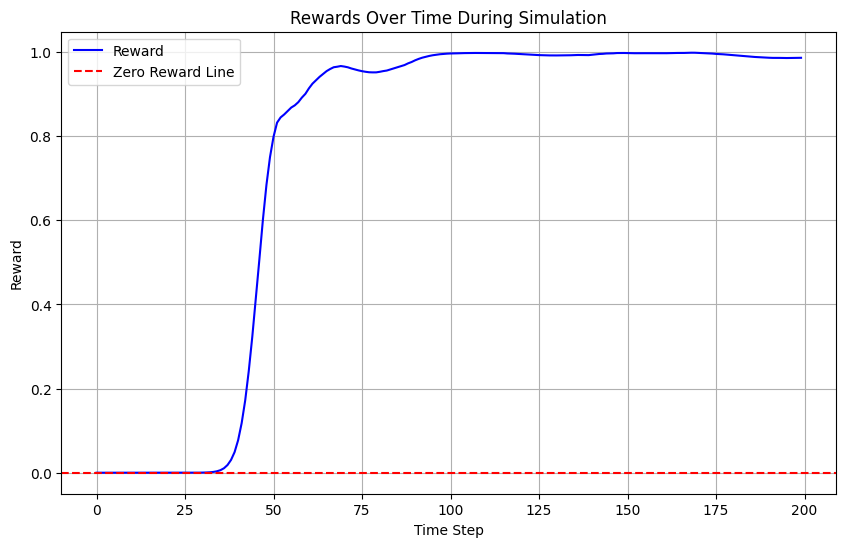

In [43]:
import matplotlib.pyplot as plt

# Plot rewards over time
time_steps = np.arange(len(rewards))  # Time steps for plotting

plt.figure(figsize=(10, 6))
plt.plot(time_steps, rewards, label="Reward", color="blue")
plt.title("Rewards Over Time During Simulation")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.axhline(0, color="red", linestyle="--", label="Zero Reward Line")  # Highlight zero line
plt.legend()
plt.grid()
plt.show()

In [44]:
def controller(x, t):
    return actions[t]

# Initial state and simulation parameters
x_init = np.array([-2, 0, 0, 0, 0, 0])
horizon_length = 200

# Simulate the quadrotor
t, state, control_inputs = quadrotor.simulate(x_init, controller, horizon_length)

quadrotor.animate_robot(
    state.astype(np.float64),
    control_inputs.astype(np.float64),
    save_mp4=True
)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAmWRtZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMg
bG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRl
cmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJf
cHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9
MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAa
IGWIhAA7//73Tr8Cm0WXagOSVwr2yqQmWblSawHypgAAAwAAAwAAAwAAEflwsC7KIS5kkAAAAwAT
MALeAaoBVgGFPzkDRP3R4AERI/cBNkGx9FZhgpDIf0VhomFmALSJYUWHreQyZfuz7RzJ0Ha6IuCb
o11Svbkf7mr9Q6uQqy6dvN9P0k2ZxUioa7YqApDwfTslU58J0+DJUY0o+Wv4z4njWLIv4/uIspot
fnsI4vj+1ld72j6Q/eeEHONo+nZh7p8upEM0pOgjT6zjCEIhgRTXr39KN3jGsREEG3WP9iIqhMpc
g4MvufkUcYY+XWlDu3M8aYfc5m86RVe/RWPZyvyZccWXyYyvr1ZTIZ9kdb9/QvvmvQNJarDWHY68
ko6lD0/wV5wwIJg13zuuI6YsiJycewEx2qvKYiF3zOpPIFJEj4Bc1MT4b0+fk9f4WeeGthQGwKLV
T9gUVmfFgTSW3gYuWFXzuSVaMq1imGJTsoG8AWCt8prhUkXesAS3yzr2SPbXt15V1kRJX5xMW1e4
3xaI7p3o1o36zYnHIiBryP8wXcKoEheOGQta91JxJm+DwxVqqu9vk48e1d2jH7aO0ibqsT2b/qz7
oNPvyeIScaFefVJNDJY1OfyvSF2Htr4p4wtHxX3HaPIDVe6n4Pcoo/9sZ+nB61KHNcDxWxRP1Hx7
VV5QkudM2W5WhNcyFXMMPd97EA32BXDqBcJctYky35tVgkvzmRi8It+HVLUtophb70XvO5RJ7SWb
qBNqt1UiICfHduuEi3fqkotEHeFmv/l+ScnP07kSLXCe4WYjDczseY/c4vSTRR95J8M9V2/TGcAx
LQ3PrLHs2GMPnZEJfxoC+wBYhBAypi/5y9xMI1ucvHymIu5d422uAoHIKPUzaUs+EoGJWAKSh7sA
/1MVNHQEdV8PWu0E9+vAQ1FB+VpOqRzSPpU8ZTdoA+s3/MkKuL6LoWzJpnOVkJbqeNHJf0QY7/Ju
BXr1pNyhkzOENG/xEF+/hIq9Dsl1rueaFnRanrrX+vwzVQ9JOE+28gAiJ62X8ieT7IDF5FQqW406
IX2VstCGazXTg7+V8hkMFrpMFOsDL+KgZSYlwHH8kymT3Mjdv6XSv1Kf9DeOm8genofy3v2S9C4p
kdZPWMt0iHrTQH7nAd0F3yccrbj92OZOmJxIDT+Q64noLyxT1HaiJ1p/c0eiywylkIaxJ7CLnH/q
kE0QvPXHS55AmdAdf5x8mtn2/kmp2uLBYiI3NzFcSDi6VXXNV3zoOLfy1u5KNTTRskX4ACX6mRjs
qi2vmA6xnlnhbd7FT3YAaBHfxPjmVU8tppXks9WA3ZEJ33y8El1B5/weqwzjroPFI/UiaSzuWtdv
wTIj4GkGmzi6FKRayGc1u2txSenUTbV9h2YNawSUFYodUAGElQur0VrBRBqsnrnZGcLqNwjbv4Vu
JqzO+Idg5jA8TkAuoFAuc/BI4HrhgaxH7ptN62v2W7BbC8fq2f8TA57nc9QxP9p9u7myvIUVXT9R
CGwHjfTiE2Q00MNAx/ncpaAKJRR6AbiC0cU9/DEP01/+fuu/lAue0lo1eFXqElPYwLVf3yo2n3ys
SCUnz8zS5E6qwMf0787ToNXfeS/3+K29s4ByjYs3d/grl54hoyezK2S1VUI9ba0Udz1wwXx2ehGs
AIbp0MI8hcAdeTWkk3mrKZNZSjy22h5/e1rJ/BgN3dz8rSvltp1Q0phw5SJ8Dr5j1/EziRM/4l+O
lJUPnAEK2tT7vPRK0zzR2sZ+a+4qZPJhUZYvFcixfSpibi1EEiyfbHqbD2T0SJ1uMCU8J8sn2Zrh
Ppnd8pJ78V5tVu0jEX92MkpEQhgcMKAKNkC9NtfvinkApmPjdVemoCQKmSey9aqErnK5Iuajx4Qw
So33bEk+h4TBZA65TYMqT7APs0ju46vzRdKnkluT7qobOyMaBIO7Vd310UDtZx6Vp+2GZNtKWmqC
U2oZWlwBBaN33ZToQTPGnO6280KBxDDtwF1J3SEZi/sgsoNfAAAzAAADAW/g7TqbqrXllFZvCo38
1M4j9kS/Qbfxqg0of1Jz44ES7MewiFtlCpOU8UUYflxyZXGkg6f6uCF7mNJ9uZ4nbjcTN/UFTOm5
xtTWZby0SRusbFpXiuQ8R4qzOFEjHaevsw9Uq8U3Yvjp5BLZWR7f5N1FAE8oSD21ErCmgHB8g2k/
ujx4xdRv3AAGUEtDxd1gxRVN6ZxLfSYArppLJO8kP+OAw9XVXdiGf2ot+IhSYkV2sq0P5xqsNX0/
0i5fqRFXtf33qVzyohdww8ZoEQFfHJ8T390jwuuZ/K+6nyrrA8cQxdEpDTXn/xqAAAA0Wdvhl+N+
/ow63otnivHwPuMpc6IsWO91OR3yPql9y48XCuPMuUOVStFDX7ThDIcOnekDsBnoIvV83s7fgLuT
vrsZXFbr8EujNfaaZ2Dvz6zHeLRQYL9idTVz1wPzOflhXAjpaY3rNX1si0G8GA8Y0UqEgbtp3iyM
hZ4gmxrq+/icuWIRcEIkqL+Cdz+UpZdtdRmyndcQBkkYsTVvVIQAoFpkHN7PlyBz3OX8kk/vtc6Z
CSOYRMUpF6kxFU6h1HdeOSe1RAyDrUBHA+N7Vc46un2h9xfAwnOzRo8YE9946MW4hOaCb/CeEXIt
rBPyeMZYSHJK9XuG2fJx/gUS6fNOLEi4dFSeucoQyDfmiqDR4SBBC2FGfjMjtPZb844DaEIgy3aL
gf7iNQTIfLMpACnj122yXnwjwAfonsdYPBJVSGTLcBkMSbvzskHqPihH7SMsuTfMrRj4pWADsSCU
QNQAAAMBIn3+lE7bxwHR0YlDAWQPxKP+s2DC7bp97p0fb7Ir1Z3tg4W0lTn4gXftZ73pKM9d3QVl
rZ5krSV9vDdTI8t4/BmD8

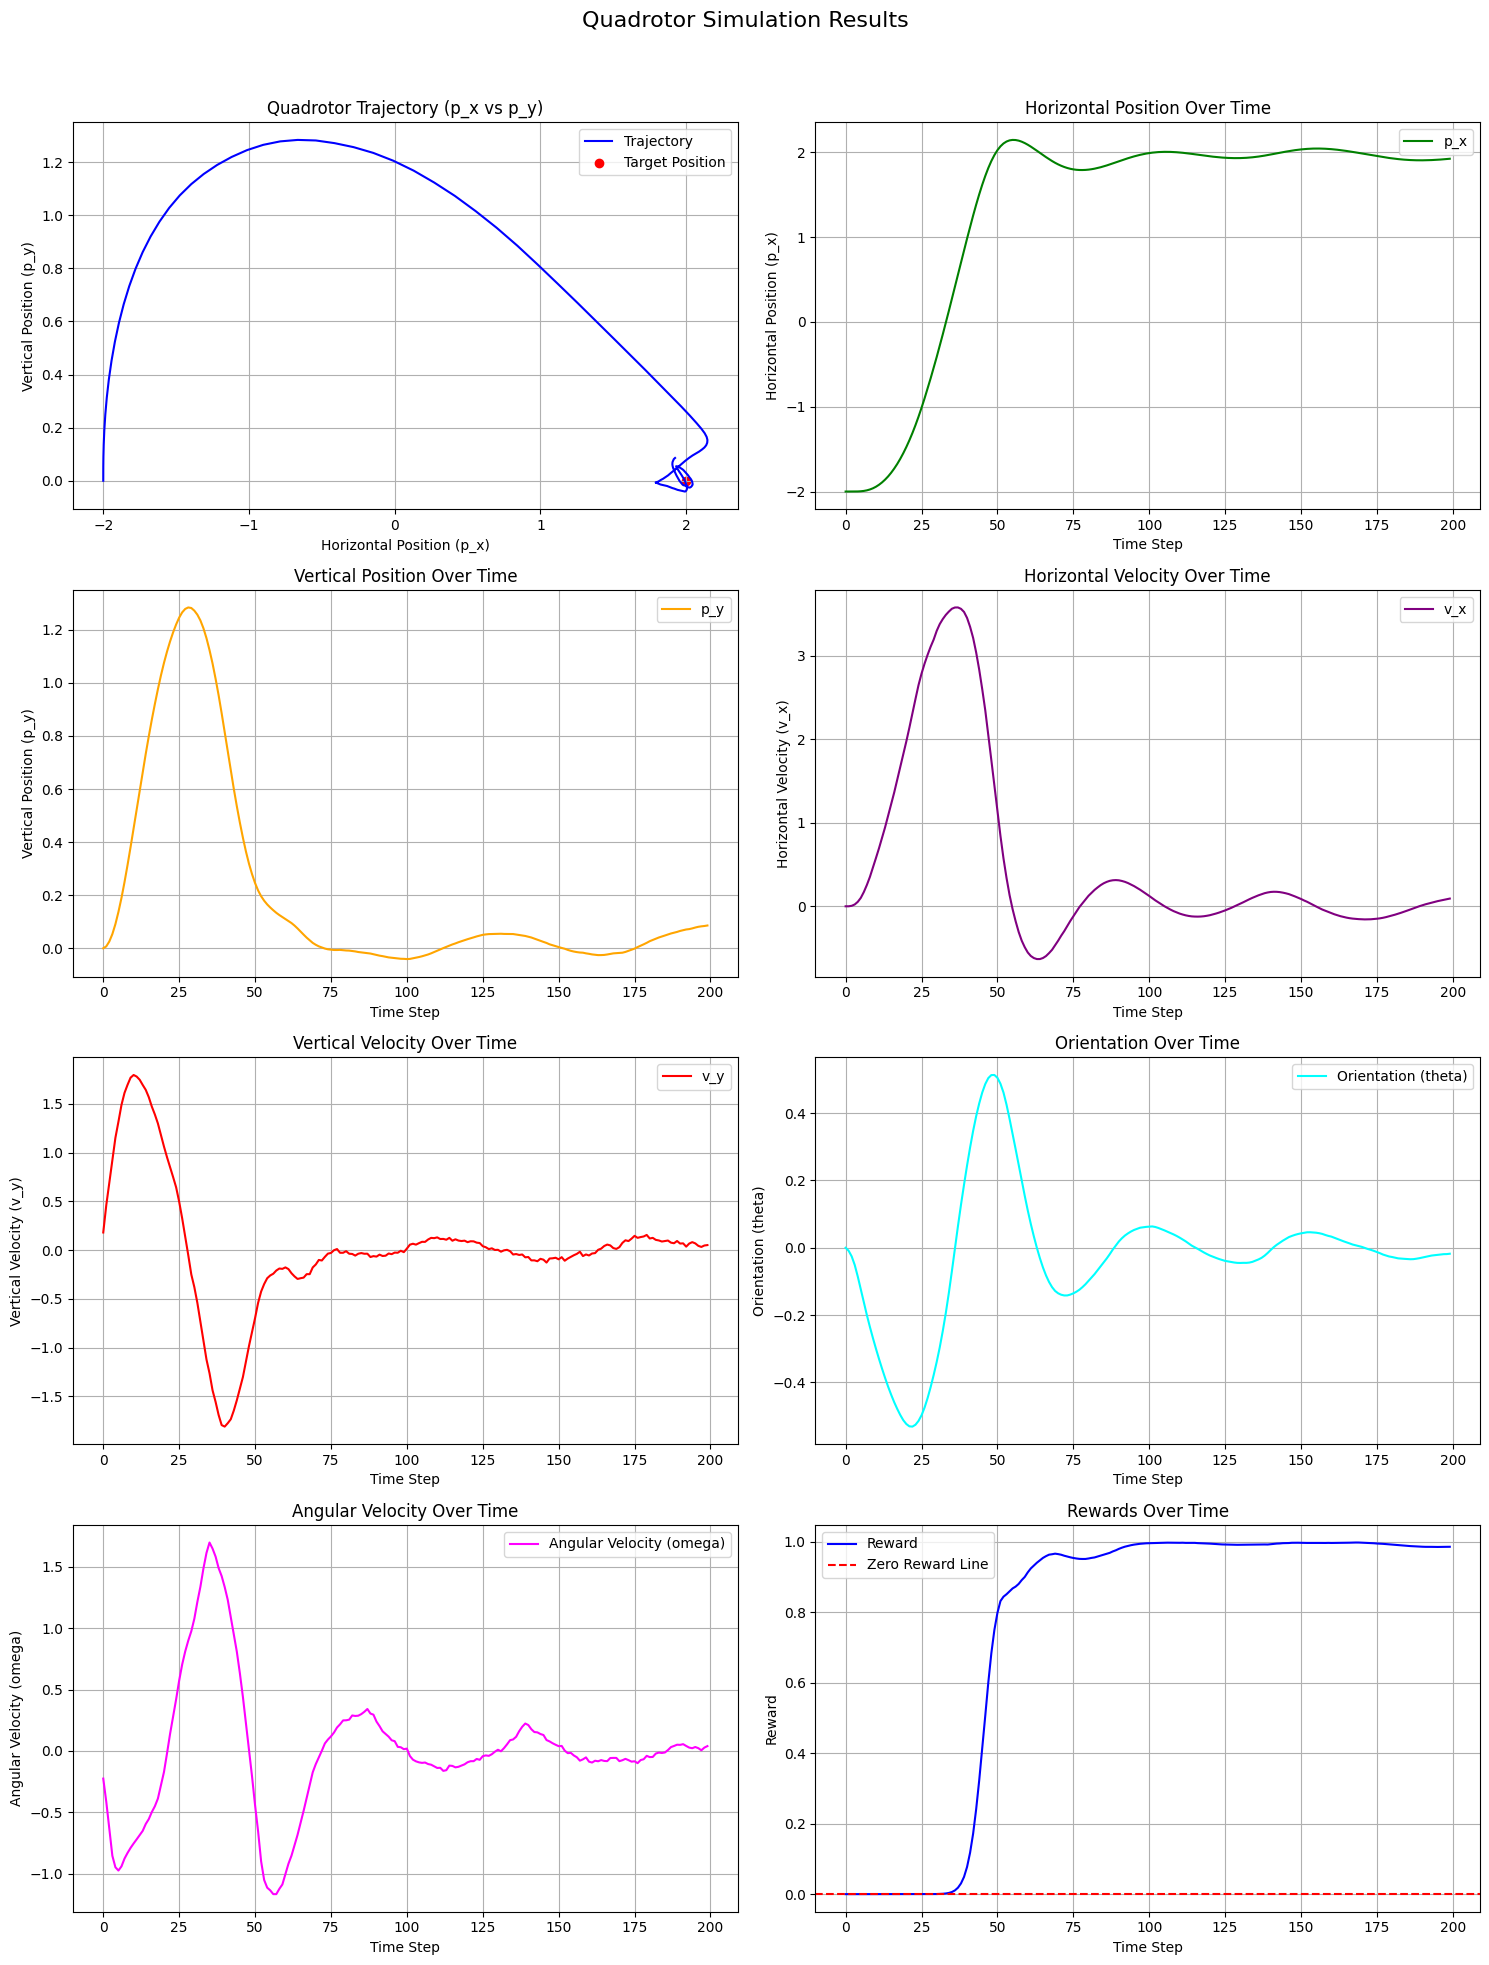

In [49]:
import matplotlib.pyplot as plt

# Assuming states_test, actions, and rewards are already populated from the simulation
time_steps = np.arange(len(states_test))  # Time steps for plotting

# Extract state variables
p_x = states_test[:, 0]  # Horizontal position
v_x = states_test[:, 1]  # Horizontal velocity
p_y = states_test[:, 2]  # Vertical position
v_y = states_test[:, 3]  # Vertical velocity
theta = states_test[:, 4]  # Orientation
omega = states_test[:, 5]  # Angular velocity

# Extract control inputs
u1 = actions[:, 0]  # Rotor 1 force
u2 = actions[:, 1]  # Rotor 2 force

# Set up the figure and axes
fig, axs = plt.subplots(4, 2, figsize=(15, 20))  # 4 rows, 2 columns grid
fig.suptitle("Quadrotor Simulation Results", fontsize=16)

# Plot quadrotor trajectory (p_x vs p_y)
axs[0, 0].plot(p_x, p_y, color="blue", label="Trajectory")
axs[0, 0].scatter(target_state[0], target_state[2], color="red", label="Target Position")
axs[0, 0].set_title("Quadrotor Trajectory (p_x vs p_y)")
axs[0, 0].set_xlabel("Horizontal Position (p_x)")
axs[0, 0].set_ylabel("Vertical Position (p_y)")
axs[0, 0].legend()
axs[0, 0].grid()

# Plot horizontal position over time
axs[0, 1].plot(time_steps, p_x, color="green", label="p_x")
axs[0, 1].set_title("Horizontal Position Over Time")
axs[0, 1].set_xlabel("Time Step")
axs[0, 1].set_ylabel("Horizontal Position (p_x)")
axs[0, 1].legend()
axs[0, 1].grid()

# Plot vertical position over time
axs[1, 0].plot(time_steps, p_y, color="orange", label="p_y")
axs[1, 0].set_title("Vertical Position Over Time")
axs[1, 0].set_xlabel("Time Step")
axs[1, 0].set_ylabel("Vertical Position (p_y)")
axs[1, 0].legend()
axs[1, 0].grid()

# Plot horizontal velocity over time
axs[1, 1].plot(time_steps, v_x, color="purple", label="v_x")
axs[1, 1].set_title("Horizontal Velocity Over Time")
axs[1, 1].set_xlabel("Time Step")
axs[1, 1].set_ylabel("Horizontal Velocity (v_x)")
axs[1, 1].legend()
axs[1, 1].grid()

# Plot vertical velocity over time
axs[2, 0].plot(time_steps, v_y, color="red", label="v_y")
axs[2, 0].set_title("Vertical Velocity Over Time")
axs[2, 0].set_xlabel("Time Step")
axs[2, 0].set_ylabel("Vertical Velocity (v_y)")
axs[2, 0].legend()
axs[2, 0].grid()

# Plot orientation (theta) over time
axs[2, 1].plot(time_steps, theta, color="cyan", label="Orientation (theta)")
axs[2, 1].set_title("Orientation Over Time")
axs[2, 1].set_xlabel("Time Step")
axs[2, 1].set_ylabel("Orientation (theta)")
axs[2, 1].legend()
axs[2, 1].grid()

# Plot angular velocity (omega) over time
axs[3, 0].plot(time_steps, omega, color="magenta", label="Angular Velocity (omega)")
axs[3, 0].set_title("Angular Velocity Over Time")
axs[3, 0].set_xlabel("Time Step")
axs[3, 0].set_ylabel("Angular Velocity (omega)")
axs[3, 0].legend()
axs[3, 0].grid()

# Plot rewards over time
axs[3, 1].plot(time_steps, rewards, label="Reward", color="blue")
axs[3, 1].set_title("Rewards Over Time")
axs[3, 1].set_xlabel("Time Step")
axs[3, 1].set_ylabel("Reward")
axs[3, 1].axhline(0, color="red", linestyle="--", label="Zero Reward Line")
axs[3, 1].legend()
axs[3, 1].grid()

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()

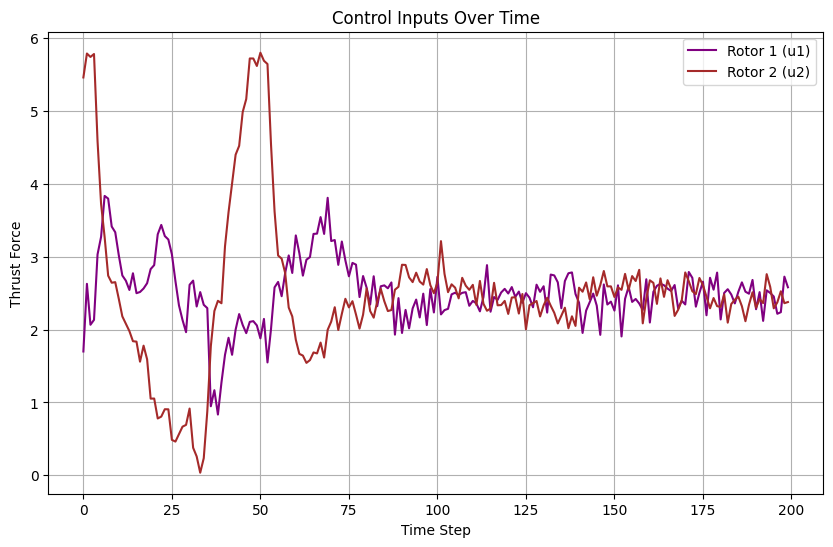

In [48]:
# Plot control inputs in a separate figure
plt.figure(figsize=(10, 6))
plt.plot(time_steps, u1, label="Rotor 1 (u1)", color="purple")
plt.plot(time_steps, u2, label="Rotor 2 (u2)", color="brown")
plt.title("Control Inputs Over Time")
plt.xlabel("Time Step")
plt.ylabel("Thrust Force")
plt.legend()
plt.grid()
plt.show()